In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import operator
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../../py_utils':
    sys.path.insert(0,'../../py_utils')

import file_utils  
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Seaborn version:  0.9.0


In [2]:
summary_team_file = '../../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../../Data/D1_teams.csv'
tournament_data_file = '../../Data/tournament_results_2018.csv'
rankings_data_file = '../../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001

# Do not use 2018 data for training
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [4]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [5]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [6]:
numeric_feature_to_scale = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_rpi', 'delta_mor']

for item in numeric_feature_to_scale:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,64,2003-03-21 00:00:00.0000000,8,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,60,9,Utah,0d037a5d-827a-44dd-8b70-57603d671d5d,58,-1,2002,Lose,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,Pacific 12,Pacific 12,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,0.346694,0.240524,0.410802,0.429263,1.259163,8.0,8.0,0.033305,-0.428353,0.367769,0.564274,-0.166349,0.296388,0.141456,-0.145034,0.158184,0.100632,-0.002273,0.166047,0.047449,-0.087067,0.572446,-0.556750
1,2003,64,2003-03-21 00:00:00.0000000,2,Florida,912f8837-1d81-4ef9-a576-a21f271d4c64,85,15,Sam Houston State,67322042-9c40-4dc2-b33a-4754c02ec82a,55,1,2002,Win,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,Southeastern,Southland,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,0.673971,0.556288,-0.376883,-0.354283,-0.024608,6.0,7.0,-0.366740,-0.048685,1.092534,-1.365443,-1.774689,1.841726,2.142615,-1.915064,-1.447144,-1.716111,-1.834885,-1.220930,-1.874068,-1.352485,-1.355216,-2.239608
2,2003,32,2003-03-23 00:00:00.0000000,2,Wake Forest,4fbebf0a-e117-4a0c-8f15-c247535a2a1b,68,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,62,-1,2002,Lose,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,Atlantic Coast,Southeastern,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,0.837609,-0.359427,0.804645,1.212810,1.831922,9.0,8.0,0.433351,1.177935,0.713928,1.666970,-1.104547,0.407285,-0.184078,-0.519187,-0.621102,-0.613088,-0.477395,-0.617187,-0.501556,-0.633853,-0.531578,-0.351523
3,2003,64,2003-03-21 00:00:00.0000000,10,Auburn,0c0608b3-f349-4f5e-9a10-7e6a744dd0d2,65,7,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,63,1,2002,Win,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,Southeastern,Atlantic 10,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-0.962413,0.714170,0.410802,-0.354283,-0.498615,8.0,5.0,1.233442,-0.859130,-0.699959,0.012926,0.369764,-0.152607,0.689340,0.301071,0.454312,0.181736,0.133476,0.247634,0.365294,0.303494,0.134341,0.058930
4,2003,4,2003-04-05 00:00:00.0000000,1,Texas,6ed15092-2670-450a-99c2-61d861e87644,95,3,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,84,-1,2002,Lose,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,Big 12,Atlantic Coast,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.019417,-0.896225,1.198488,-0.746056,0.548152,7.0,6.0,0.433351,-0.4867

In [7]:
feature_columns = numeric_feature_to_scale  + ['season_t', 'top_conf_t', 'top_conf_o']

In [8]:
feature_data = tourney_comp_ratings[feature_columns].copy()
#feature_data

#### Setup feature columns for Tensorflow

In [9]:
tf_top_conf_t = tf.feature_column.numeric_column('top_conf_t')
tf_top_conf_o = tf.feature_column.numeric_column('top_conf_o')
tf_margin_victory = tf.feature_column.numeric_column('delta_margin_victory_avg')
tf_delta_fg = tf.feature_column.numeric_column('delta_fg_pct')
tf_delta_off_rebs = tf.feature_column.numeric_column('delta_off_rebs_avg')
tf_delta_def_rebs = tf.feature_column.numeric_column('delta_def_rebs_avg')
tf_delta_ft = tf.feature_column.numeric_column('delta_ft_pct')
tf_delta_to = tf.feature_column.numeric_column('delta_to_net_avg')
tf_delta_win = tf.feature_column.numeric_column('delta_win_pct')
tf_delta_off_rating = tf.feature_column.numeric_column('delta_off_rating')
tf_delta_ft_att = tf.feature_column.numeric_column('delta_ft_att_avg')
tf_delta_seed = tf.feature_column.numeric_column('delta_seed')
tf_delta_srs = tf.feature_column.numeric_column('delta_srs')
tf_delta_sos = tf.feature_column.numeric_column('delta_sos')
tf_delta_sag = tf.feature_column.numeric_column('delta_sag')
tf_delta_wlk = tf.feature_column.numeric_column('delta_wlk')
tf_delta_wol = tf.feature_column.numeric_column('delta_wol')
tf_delta_rth = tf.feature_column.numeric_column('delta_rth')
tf_delta_col = tf.feature_column.numeric_column('delta_col')
tf_delta_pom = tf.feature_column.numeric_column('delta_pom')
tf_delta_dol = tf.feature_column.numeric_column('delta_dol')
tf_delta_rpi = tf.feature_column.numeric_column('delta_rpi')
tf_delta_mor = tf.feature_column.numeric_column('delta_mor')

tf_feat_cols = [tf_margin_victory, tf_delta_fg, tf_delta_off_rebs, 
                tf_delta_def_rebs, tf_delta_ft, tf_delta_to, tf_delta_win, tf_delta_off_rating, 
                tf_delta_ft_att, tf_delta_seed, tf_delta_srs, tf_delta_sos, tf_delta_sag, 
                tf_delta_wlk, tf_delta_wol, tf_delta_rth, tf_delta_col, tf_delta_pom,
                tf_delta_dol, tf_delta_rpi, tf_delta_mor]

In [10]:
X= feature_data[feature_data['season_t']<= stop_tournament]
tourney_comp_ratings['label'] = tourney_comp_ratings.apply(lambda x: 0 if x.game_result==-1 else 1, axis=1)
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['label']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(782, 23)
(782,)
(196, 23)
(196,)


,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,top_conf_t,top_conf_o
784,-0.471498,-0.454156,0.016960,-0.354283,1.239413,0.833397,-0.384545,-0.499559,-0.262748,0.369764,-0.891917,-0.949954,1.365967,1.623240,1.560514,1.246618,1.406167,1.131011,1.584534,1.396083,1.372380,0,1
125,1.328524,0.366830,-0.770726,0.037490,-0.755369,-0.366740,1.929969,1.368372,-0.262748,-0.970519,0.501051,-0.454387,-0.375282,-0.543173,-0.434658,-0.368796,-0.486648,-0.371529,-0.493251,-0.496530,-0.283115,0,1
236,0.510332,0.714170,-1.558411,-1.137829,1.417166,-1.166832,1.031909,1.999679,1.115622,-0.434406,0.402777,0.016474,-0.188206,-0.200287,-0.272449,-0.205897,-0.258205,-0.198159,-0.305781,-0.233667,-0.214706,0,0
719,0.019417,-0.296274,0.016960,-0.746056,-0.301112,0.433351,0.330983,-0.392916,-1.089769,-0.032321,-0.090397,0.076058,0.085214,-0.013259,0.019527,-0.002273,-0.095031,-0.255949,0.162892,-0.268716,-0.118933,0,0
808,0.019417,-1.433023,1.986174,0.821036,-0.992373,1.633488,-0.041383,-1.212148,0.288600,-1.506632,1.137579,1.667395,-0.950902,-1.057501,-0.969949,-1.359763,-1.318834,-0.833849,-1.243128,-0.776917,-1.021930,1,0


#### Baseline Model

In [12]:
input_func = tf.estimator.inputs.pandas_input_fn(x=X_train, y=y_train, batch_size=50, num_epochs=None, shuffle=True )

In [13]:
model = tf.estimator.LinearClassifier(feature_columns= tf_feat_cols, n_classes=2)
model.train(input_fn = input_func, steps=15000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\CHIPK\\AppData\\Local\\Temp\\tmp19n8bcdp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000279A1919470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for up

INFO:tensorflow:global_step/sec: 409.252
INFO:tensorflow:loss = 12.377058, step = 5901 (0.244 sec)
INFO:tensorflow:global_step/sec: 417.769
INFO:tensorflow:loss = 18.014563, step = 6001 (0.239 sec)
INFO:tensorflow:global_step/sec: 402.736
INFO:tensorflow:loss = 16.671503, step = 6101 (0.249 sec)
INFO:tensorflow:global_step/sec: 390.089
INFO:tensorflow:loss = 21.326103, step = 6201 (0.254 sec)
INFO:tensorflow:global_step/sec: 419.542
INFO:tensorflow:loss = 16.813658, step = 6301 (0.238 sec)
INFO:tensorflow:global_step/sec: 416.989
INFO:tensorflow:loss = 13.495249, step = 6401 (0.240 sec)
INFO:tensorflow:global_step/sec: 423.077
INFO:tensorflow:loss = 21.22383, step = 6501 (0.237 sec)
INFO:tensorflow:global_step/sec: 414.298
INFO:tensorflow:loss = 14.921574, step = 6601 (0.242 sec)
INFO:tensorflow:global_step/sec: 411.016
INFO:tensorflow:loss = 17.240377, step = 6701 (0.244 sec)
INFO:tensorflow:global_step/sec: 382.662
INFO:tensorflow:loss = 23.293715, step = 6801 (0.259 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 412.666
INFO:tensorflow:loss = 17.15998, step = 14201 (0.241 sec)
INFO:tensorflow:global_step/sec: 417.734
INFO:tensorflow:loss = 14.0060005, step = 14301 (0.238 sec)
INFO:tensorflow:global_step/sec: 421.282
INFO:tensorflow:loss = 20.153904, step = 14401 (0.238 sec)
INFO:tensorflow:global_step/sec: 410.926
INFO:tensorflow:loss = 15.255949, step = 14501 (0.244 sec)
INFO:tensorflow:global_step/sec: 401.127
INFO:tensorflow:loss = 17.689682, step = 14601 (0.249 sec)
INFO:tensorflow:global_step/sec: 426.621
INFO:tensorflow:loss = 23.661976, step = 14701 (0.232 sec)
INFO:tensorflow:global_step/sec: 426.651
INFO:tensorflow:loss = 13.0533695, step = 14801 (0.234 sec)
INFO:tensorflow:global_step/sec: 416.019
INFO:tensorflow:loss = 15.070827, step = 14901 (0.242 sec)
INFO:tensorflow:Saving checkpoints for 15000 into C:\Users\CHIPK\AppData\Local\Temp\tmp19n8bcdp\model.ckpt.
INFO:tensorflow:Loss for final step: 19.84122.


In [14]:
eval_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, y=y_test, batch_size=50, num_epochs=1, shuffle=False)

In [15]:
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-29-15:37:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmp19n8bcdp\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-29-15:37:03
INFO:tensorflow:Saving dict for global step 15000: accuracy = 0.81632656, accuracy_baseline = 0.54591835, auc = 0.87750715, auc_precision_recall = 0.8775251, average_loss = 0.45820743, global_step = 15000, label/mean = 0.54591835, loss = 22.452164, precision = 0.8141593, prediction/mean = 0.5597494, recall = 0.8598131
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15000: C:\Users\CHIPK\AppData\Local\Temp\tmp19n8bcdp\model.ckpt-15000


{'accuracy': 0.81632656,
 'accuracy_baseline': 0.54591835,
 'auc': 0.87750715,
 'auc_precision_recall': 0.8775251,
 'average_loss': 0.45820743,
 'label/mean': 0.54591835,
 'loss': 22.452164,
 'precision': 0.8141593,
 'prediction/mean': 0.5597494,
 'recall': 0.8598131,
 'global_step': 15000}

#### Identify the predicted results for the test samples

In [16]:
pred_input_func = tf.estimator.inputs.pandas_input_fn(x=X_test, batch_size=50, num_epochs=1, shuffle=False)
predictions_test = model.predict(pred_input_func)
test_predictions = list(predictions_test)
test_predictions

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmp19n8bcdp\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([1.9136101], dtype=float32),
  'logistic': array([0.8714242], dtype=float32),
  'probabilities': array([0.12857582, 0.8714242 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([1.5943347], dtype=float32),
  'logistic': array([0.8312251], dtype=float32),
  'probabilities': array([0.1687749, 0.8312251], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([4.3987007], dtype=float32),
  'logistic': array([0.987856], dtype=float32),
  'probabilities': array([0.01214401, 0.987856  ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([2.3381152], dtype=float32),
  'logistic': array([0.9119849], dtype=float32),
  'probabilities': array([0.08801509, 0.9119849 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object)},
 {'logits': array([

In [18]:
test_preds = [pred['class_ids'][0] for pred in test_predictions ]

[1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1]

In [19]:
y_test_df = y_test.to_frame('y_actual')
y_test_df['y_predict'] = test_preds


In [21]:
missed_predictions = y_test_df[y_test_df['y_actual'] != y_test_df['y_predict']].copy()
missed_predictions.reset_index(inplace=True)
missed_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_predictions = missed_predictions.sort_values(by=['sample_index'])
len(missed_predictions.index)

36

array([[68, 21],
       [15, 92]], dtype=int64)

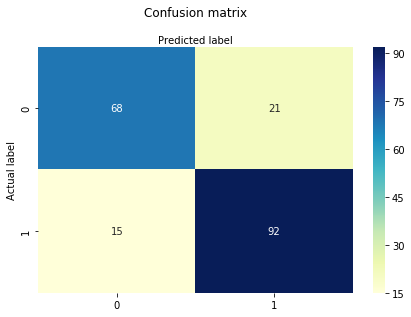

In [35]:
utils.display_confusion_matrix(y_test, test_preds)

#### Predict 2018

In [22]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year]
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['label']
X_season.shape

(67, 24)

In [23]:
pred_2018_input_func = tf.estimator.inputs.pandas_input_fn(x=X_season, batch_size=10, num_epochs=1, shuffle=False)
predictions_2018 = model.predict(pred_2018_input_func)
pred_2018 = list(predictions_2018)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\CHIPK\AppData\Local\Temp\tmp19n8bcdp\model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [30]:
preds_2018 = [pred['class_ids'][0] for pred in pred_2018 ]
y_2018_df = y_season.to_frame('y_actual')
y_2018_df['y_predict'] = preds_2018

In [26]:
missed_2018_predictions = y_2018_df[y_2018_df['y_actual'] != y_2018_df['y_predict']].copy()

missed_2018_predictions.reset_index(inplace=True)
missed_2018_predictions.rename({"index":"sample_index"}, axis='columns', inplace=True)
missed_2018_predictions = missed_2018_predictions.sort_values(by=['sample_index'])
#len(missed_2018_predictions.index)
missed_2018_predictions

,sample_index,y_actual,y_predict
0,985,1,0
1,988,0,1
2,998,0,1
3,1019,1,0
4,1021,1,0
5,1022,0,1
6,1024,0,1
7,1031,1,0
8,1033,1,0
9,1038,0,1


array([[28,  5],
       [ 5, 29]], dtype=int64)

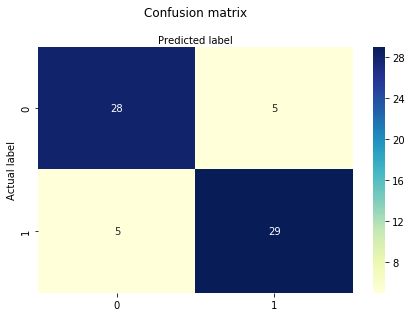

In [34]:
utils.display_confusion_matrix(y_season, preds_2018)